# Projet 10 : Détectez des faux billets avec R ou Python

# Récupération et exploration des données

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import t, shapiro
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_white
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import pickle

In [2]:
# Importations du jeu de données "test"
billet_prod = pd.read_csv(r"C:\Users\open_\Desktop\DATA ANALYST\10 - PROJETS\Projet 10\Projet - données\billets_production.csv")
billet_prod

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [3]:
# Importation et informations du jeu de données
df_billet = pd.read_csv(r"C:\\Users\\open_\\P10_Détectez_des_faux_billets_avec_R_ou_Python\\billets.csv", sep=";", decimal=".")
display(df_billet.head())
print("shape :", df_billet.shape, "\n\n")
display(df_billet.info())
display(df_billet.describe())

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


shape : (1500, 7) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


None

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


Valeurs uniques :
 is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64
Doublons : 0


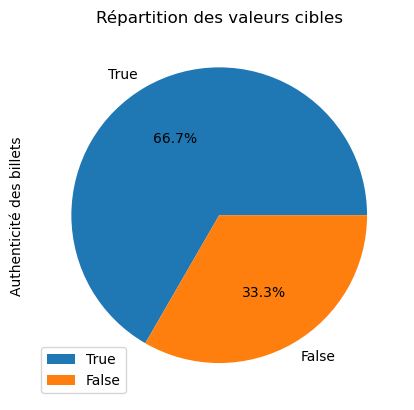

Valeurs nulles :
 is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

Valeurs nulles :


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36


In [4]:
# Détection des valeurs uniques
print("Valeurs uniques :\n", df_billet.nunique())

# Détection des doublons
print("Doublons :", df_billet.duplicated().sum())

# Répartition des valeurs cibles
df_billet.iloc[:,0].value_counts().plot(kind="pie", autopct='%1.1f%%')
plt.legend()
plt.title("Répartition des valeurs cibles")
plt.ylabel("Authenticité des billets")
plt.show()

# Détection des valeurs nulles
print("Valeurs nulles :\n", df_billet.isnull().sum())

# Affichage des valeurs nulles
val_nul = df_billet.loc[df_billet["margin_low"].isnull(), :]
print("\nValeurs nulles :")
val_nul.head()

Le jeu de données comporte une variable "is_genuine" ne comportant que 2 valeurs uniques, il s'agit donc d'un comportement de type binaire que l'on pourra traiter avec une régression logistique.

Les valeurs cibles sont réparties en 2/3 pour les billets authentiques (1000) et 1/3 pour les faux billets (500).

La variable margin_low comporte 37 valeurs nulles que l'on va prédire selon un modèle de régression linéaire en utilisant les variables qui expliquent au mieux le jeu de données.

# Test de non colinéarité par régression linéaire 

In [5]:
# Régression linéaire multiple
reg_multi = smf.ols("margin_low~diagonal+height_left+height_right+margin_up+length", data=df_billet).fit()
display(reg_multi.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Sun, 18 Jun 2023   Prob (F-statistic):          2.60e-202
Time:                        10:19:05   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382      0.017       4.055      41.935
diagonal        -0.1111      0.041     -2.680      0.007      -0.192      -0.030
height_left      0.1841      0.045      4.113      0.000       0.096       0.272
height_right     0.2571      0.043      5.978      0.000       0.173       0.342
margin_up        0.2562      0.064      3.980      0.000       0.130       0.382
length          -0.4091      0.018    -22.627      0.000      -0.445      -0.374
==============================================================================
Omnibus:                       73.627   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.862
Skew:                           0.482   Prob(JB):                     1.53e-21
Kurtosis:                       3.801   Cond. No.                     1.94e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.94e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Grâce aux tests statistiques, nous constatons que toutes les p-valeurs sont inférieures au seuil que nous nous sommes fixé à 5 %. Cependant nous constatons une forte colinéarité des variables de valeur 1.94e+05. 

Identifions les variables les moins colinéaires de margin_low qui seront les plus significatives pour une régréssion linéaire simple, selon la méthode forward. 
La méthode forward initialise la procédure en intégrant seulement la constante et en introduisant les régresseurs un à un pour évaluer leur colinéarité avec la constante étudiée.

In [6]:
# Régression linéaire
reg_multi = smf.ols("margin_low~diagonal", data=df_billet).fit()
display(reg_multi.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             margin_low   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     18.40
Date:                Sun, 18 Jun 2023   Prob (F-statistic):           1.90e-05
Time:                        10:19:06   Log-Likelihood:                -1466.8
No. Observations:                1463   AIC:                             2938.
Df Residuals:                    1461   BIC:                             2948.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     46.1660      9.716      4.752      0.000      27.108      65.224
diagonal      -0.2424      0.057     -4.290      0.000      -0.353      -0.132
==============================================================================
Omnibus:                      135.690   Durbin-Watson:                   0.825
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              173.424
Skew:                           0.836   Prob(JB):                     2.20e-38
Kurtosis:                       3.226   Cond. No.                     9.68e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.68e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

La colinéarité est toujours trop forte.

In [7]:
# Régression linéaire
reg_multi = smf.ols("margin_low~height_left", data=df_billet).fit()
display(reg_multi.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             margin_low   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     147.3
Date:                Sun, 18 Jun 2023   Prob (F-statistic):           2.29e-32
Time:                        10:19:06   Log-Likelihood:                -1405.7
No. Observations:                1463   AIC:                             2815.
Df Residuals:                    1461   BIC:                             2826.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -65.2715      5.747    -11.357      0.000     -76.546     -53.997
height_left     0.6705      0.055     12.137      0.000       0.562       0.779
==============================================================================
Omnibus:                      107.668   Durbin-Watson:                   1.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.277
Skew:                           0.715   Prob(JB):                     5.14e-29
Kurtosis:                       3.304   Cond. No.                     3.61e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

La colinéarité est toujours trop forte.

In [8]:
# Régression linéaire
reg_multi = smf.ols("margin_low~height_right", data=df_billet).fit()
display(reg_multi.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             margin_low   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     263.8
Date:                Sun, 18 Jun 2023   Prob (F-statistic):           1.16e-54
Time:                        10:19:06   Log-Likelihood:                -1354.5
No. Observations:                1463   AIC:                             2713.
Df Residuals:                    1461   BIC:                             2724.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -78.7353      5.124    -15.366      0.000     -88.786     -68.684
height_right     0.8008      0.049     16.242      0.000       0.704       0.898
==============================================================================
Omnibus:                      108.273   Durbin-Watson:                   1.168
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.300
Skew:                           0.707   Prob(JB):                     3.08e-29
Kurtosis:                       3.394   Cond. No.                     3.33e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.33e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

La colinéarité est toujours trop forte.

In [9]:
# Régression linéaire
reg_multi = smf.ols("margin_low~length", data=df_billet).fit()
display(reg_multi.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             margin_low   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     1169.
Date:                Sun, 18 Jun 2023   Prob (F-statistic):          8.98e-189
Time:                        10:19:06   Log-Likelihood:                -1045.8
No. Observations:                1463   AIC:                             2096.
Df Residuals:                    1461   BIC:                             2106.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     61.5960      1.670     36.881      0.000      58.320      64.872
length        -0.5069      0.015    -34.196      0.000      -0.536      -0.478
==============================================================================
Omnibus:                       95.156   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.014
Skew:                           0.552   Prob(JB):                     1.31e-29
Kurtosis:                       3.980   Cond. No.                     1.45e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

La colinéarité est toujours trop forte.

In [10]:
# Régression linéaire
reg_multi = smf.ols("margin_low~margin_up", data=df_billet).fit()
display(reg_multi.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             margin_low   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     334.5
Date:                Sun, 18 Jun 2023   Prob (F-statistic):           1.92e-67
Time:                        10:19:06   Log-Likelihood:                -1325.1
No. Observations:                1463   AIC:                             2654.
Df Residuals:                    1461   BIC:                             2665.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5831      0.214      2.725      0.007       0.163       1.003
margin_up      1.2378      0.068     18.288      0.000       1.105       1.371
==============================================================================
Omnibus:                      112.835   Durbin-Watson:                   1.321
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              141.027
Skew:                           0.693   Prob(JB):                     2.38e-31
Kurtosis:                       3.628   Cond. No.                         47.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Il n'y a quasiment plus de colinéarité, la valeur est descendu à 47.5, nous retenons donc margin_up pour effectuer notre régression linéaire simple qui prédira les valeurs de margin_low.

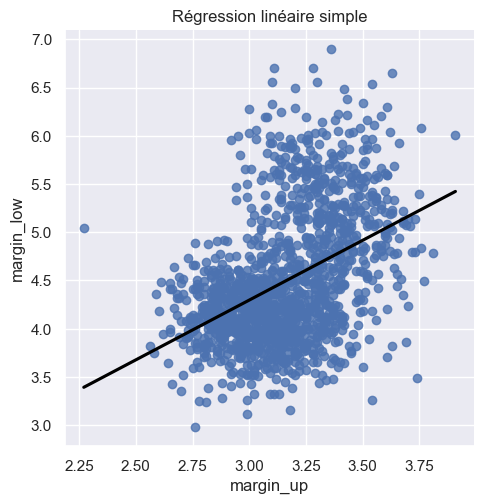

In [11]:
# Régression linéaire simple
sns.set()
sns.lmplot(x="margin_up", y="margin_low", data=df_billet, ci=None, line_kws={'color':'black'})
plt.title("Régression linéaire simple")
plt.show()

Nous notons une valeur outlier de la variable margin_up se situant autour des 2,25 mm.
Nous constaterons plus loin, lors de la représentation graphique en boîte des variables indépendantes, que cette valeur est éloignée du groupe de valeurs. 
Cependant son influence reste relativement faible car elle est isolée.

# Test de la normalité des résidus

Nous utilisons un test de Shapiro Wilk pour tester la normalité des résidus sur la dernière régression linéaire.

In [12]:
# Test de Shapiro Wilk
shapiro(reg_multi.resid)

ShapiroResult(statistic=0.9706372022628784, pvalue=1.1069878881622371e-16)

Ici la P-valeur est inférieure au seuil que nous nous fixons à 5%, c'est à dire que les résidus ne suivent pas une loi gaussienne.

Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante permettent de dire que les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes, même si le résidu n'est pas considéré comme étant gaussien.

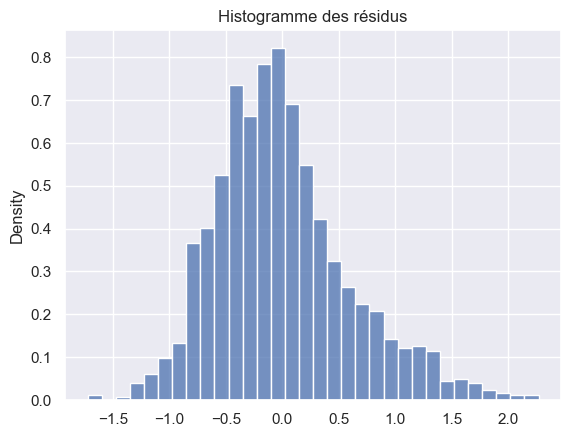

In [13]:
# Histogramme des résidus
sns.histplot(data=reg_multi.resid, stat="density")
plt.title("Histogramme des résidus")
plt.show()

# Test de l'homoscédasticité

Nous utilisons le test de White qui compare les variances des résidus.

In [14]:
# Calcul des résidus de la régression
residuals = reg_multi.resid

# Test de White
white_test = het_white(residuals, reg_multi.model.exog)

# Affichage des résultats
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(lzip(labels, white_test))

[('LM Statistic', 47.02593818189114), ('LM-Test p-value', 6.143944311918418e-11), ('F-Statistic', 24.24404217454537), ('F-Test p-value', 4.3854019028887314e-11)]


La statistique LM est associée au test de White qui est utilisé pour évaluer l'hypothèse nulle d'homoscédasticité.

La statistique F est la statistique de test alternative pour le test de White.

Les P-valeurs relatives aux tests statistiques LM et F sont inférieures au seuil fixé à 5%, c'est à dire qu'il y a des preuves d'hétéroscédasticité ou de non égalité des variances.

# Prédiction des valeurs manquantes de margin_low grâce à une régression linéaire simple

In [15]:
# Récupération de l'index des lignes dont margin_low est nulle
index_margin_low = df_billet.loc[df_billet["margin_low"].isnull(), :].index.tolist()
print(index_margin_low)
len(index_margin_low)

[72, 99, 151, 197, 241, 251, 284, 334, 410, 413, 445, 481, 505, 611, 654, 675, 710, 739, 742, 780, 798, 844, 845, 871, 895, 919, 945, 946, 981, 1076, 1121, 1176, 1303, 1315, 1347, 1435, 1438]


37

In [16]:
# Liste des valeurs margin_up des billets dont la valeur margin_low est nulle
liste_margin_up = df_billet.loc[df_billet["margin_low"].isnull(), "margin_up"].tolist()
print(liste_margin_up)
len(liste_margin_up)

[3.25, 3.14, 3.02, 3.62, 3.02, 2.95, 3.23, 3.0, 3.12, 3.16, 3.01, 2.71, 2.98, 3.3, 2.7, 2.56, 3.07, 3.09, 3.24, 3.13, 3.01, 2.99, 2.9, 3.07, 2.98, 2.58, 3.02, 3.27, 2.99, 3.21, 3.17, 3.02, 2.93, 3.4, 3.61, 3.56, 3.24]


37

In [17]:
# Prévision des valeurs de margin_low en fonction de la liste margin_up
liste_margin_low_prev = []

for i in liste_margin_up :
    a_prevoir = pd.DataFrame({'margin_up': i}, index=[0])
    margin_low_prev = reg_multi.predict(a_prevoir)
    val_margin_low_prev = round(margin_low_prev[0], 2).tolist()
    liste_margin_low_prev.append(val_margin_low_prev)
    
print(liste_margin_low_prev)
len(liste_margin_low_prev)

[4.61, 4.47, 4.32, 5.06, 4.32, 4.23, 4.58, 4.3, 4.45, 4.49, 4.31, 3.94, 4.27, 4.67, 3.93, 3.75, 4.38, 4.41, 4.59, 4.46, 4.31, 4.28, 4.17, 4.38, 4.27, 3.78, 4.32, 4.63, 4.28, 4.56, 4.51, 4.32, 4.21, 4.79, 5.05, 4.99, 4.59]


37

In [18]:
# Remplacement des valeurs nulles de margin_low par les valeurs prédites grâce à la régression linéaire
df_billet.loc[df_billet["margin_low"].isnull(), "margin_low"] = liste_margin_low_prev

In [19]:
# Vérification des valeurs nulles
display(df_billet.isnull().sum())

# Affichage des nouvelles valeurs prédites de margin_low
df_billet.loc[index_margin_low,:]

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,4.61,3.25,112.79
99,True,171.93,104.07,104.18,4.47,3.14,113.08
151,True,172.07,103.80,104.38,4.32,3.02,112.93
197,True,171.45,103.66,103.80,5.06,3.62,113.27
241,True,171.83,104.14,104.06,4.32,3.02,112.36
251,True,171.80,103.26,102.82,4.23,2.95,113.22
284,True,171.92,103.83,103.76,4.58,3.23,113.29
334,True,171.85,103.70,103.96,4.30,3.00,113.36
410,True,172.56,103.72,103.51,4.45,3.12,112.95
413,True,172.30,103.66,103.50,4.49,3.16,112.95


# Séparation des vrais et faux billets dans 2 dataframes distincts

In [20]:
# Liste des vrais billets
billet_v = df_billet.loc[df_billet["is_genuine"]==True, :]
display(billet_v.head())
billet_v.shape

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


(1000, 7)

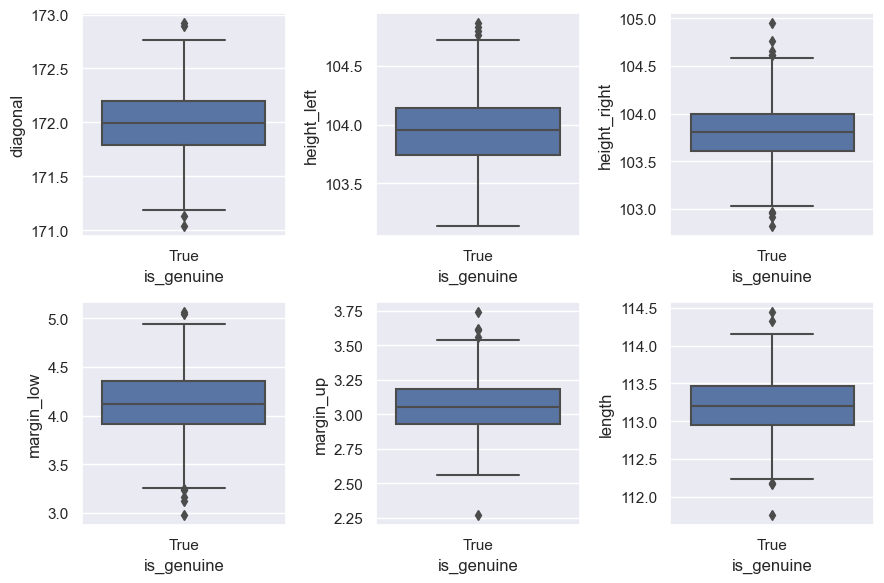

In [21]:
# Représentation des variables des vrais billets
col = billet_v.columns[1:]
fig, axes = plt.subplots(2, 3, figsize=(9, 6))

for i, ax in enumerate(axes.flatten()):
    if i < len(col):
        sns.boxplot(x="is_genuine", y=col[i], data=billet_v, ax=ax)
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [22]:
# Liste des faux billets
billet_f = df_billet.loc[df_billet["is_genuine"]==False, :]
display(billet_f.head())
billet_f.shape

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1000,False,172.28,103.95,103.91,4.78,3.31,111.40
1001,False,171.92,103.86,104.30,4.96,3.13,111.29
1002,False,171.59,104.14,104.38,4.97,3.47,111.22
1003,False,172.02,104.33,104.33,5.19,3.21,111.99
1004,False,172.55,104.25,104.23,5.60,3.13,111.72


(500, 7)

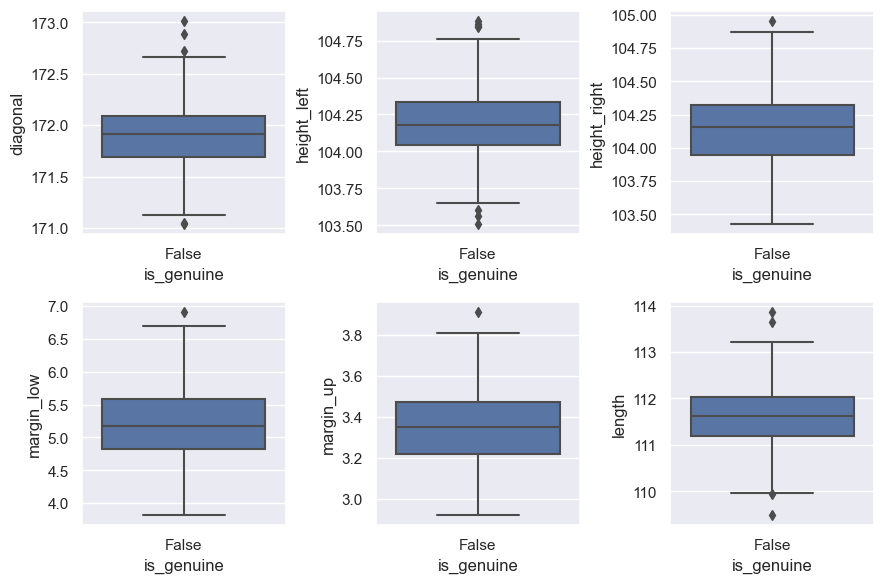

In [23]:
# Représentation des variables des faux billets
col = billet_f.columns[1:]
fig, axes = plt.subplots(2, 3, figsize=(9, 6))

for i, ax in enumerate(axes.flatten()):
    if i < len(col):
        sns.boxplot(x="is_genuine", y=col[i], data=billet_f, ax=ax)
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

# Régression logistique pour identifier les variables significatives

Réalisons une régression logistique du jeu de données entier pour vérifier les variables qui expliquent au mieux l'authenticité d'un billet.
Nous utilisons une régression logistique car nous souhaitons vérifier une variable qualitative (authenticité du billet) en fonction de variables quantitatives (les caractéristiques du billet).

In [24]:
# Simplification du nom du dataframe
billet = df_billet
billet.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [25]:
# Régression logistique avec toutes les variables
reg_log = smf.glm("is_genuine~diagonal+height_left+height_right+margin_low+margin_up+length", data=billet, family=sm.families.Binomial()).fit()
reg_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             Generalized Linear Model Regression Results                             
=====================================================================================================
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1500
Model:                                                   GLM   Df Residuals:                     1493
Model Family:                                       Binomial   Df Model:                            6
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -43.125
Date:                                       Sun, 18 Jun 2023   Deviance:                       86.249
Time:                                               10:19:10   Pearson chi2:                 3.71e+03
No. Iterations:                                           10   Pseudo R-squ. (CS):             0.7034
Covariance Type:                                   nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      161.6113    234.882      0.688      0.491    -298.748     621.971
diagonal         0.0568      1.081      0.053      0.958      -2.061       2.175
height_left      2.0610      1.087      1.895      0.058      -0.070       4.192
height_right     2.4237      1.057      2.294      0.022       0.353       4.495
margin_low       5.5928      0.906      6.174      0.000       3.817       7.368
margin_up        9.0785      1.903      4.770      0.000       5.348      12.809
length          -6.1554      0.869     -7.081      0.000      -7.859      -4.452
================================================================================
"""

Les variables les plus significatives sont celles qui ont un coefficient élevé que ce soit dans le positif comme dans le négatif. Elle exprime une relation positive ou négative entre la variable prédictrice et la variable cible. Il s'agit à première vue de la marge haute (9.07) et de la marge basse (5.59), ainsi que de la longueur (-6.15), de la hauteur droite (2.42) et de la hauteur gauche (2.06).

Grâce aux tests statistiques, nous détectons les p-valeurs supérieures au seuil que nous nous sommes fixé à 5 %. Nous les écarterons du modèle progressivement, en commençant par la valeur la plus élevée, selon la procédure descendante (ou backward).

Le logarithme de vraisemblance n'obtient pas une valeur élevée (-43.125), c'est à dire que les valeurs prédites ne sont pas suffisamment proches des valeurs réelles.

Le pseudo R-carré est un coefficient qui calcule à quel point les valeurs prédites sont proches des valeurs réelles. On obtient 70%, ce qui est raisonnable.

In [26]:
# Régression logistique avec les variables retenues selon la procédure backward
reg_log = smf.glm("is_genuine~height_left+height_right+margin_low+margin_up+length", data=billet, family=sm.families.Binomial()).fit()
reg_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             Generalized Linear Model Regression Results                             
=====================================================================================================
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1500
Model:                                                   GLM   Df Residuals:                     1494
Model Family:                                       Binomial   Df Model:                            5
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -43.126
Date:                                       Sun, 18 Jun 2023   Deviance:                       86.252
Time:                                               10:19:10   Pearson chi2:                 3.71e+03
No. Iterations:                                           10   Pseudo R-squ. (CS):             0.7034
Covariance Type:                                   nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      171.0155    152.312      1.123      0.262    -127.511     469.542
height_left      2.0625      1.088      1.896      0.058      -0.069       4.194
height_right     2.4187      1.053      2.296      0.022       0.354       4.483
margin_low       5.5754      0.840      6.638      0.000       3.929       7.222
margin_up        9.0633      1.880      4.821      0.000       5.379      12.748
length          -6.1477      0.856     -7.185      0.000      -7.825      -4.471
================================================================================
"""

In [27]:
# Régression logistique avec les variables retenues selon la procédure backward
reg_log = smf.glm("is_genuine~height_right+margin_low+margin_up+length", data=billet, family=sm.families.Binomial()).fit()
reg_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             Generalized Linear Model Regression Results                             
=====================================================================================================
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1500
Model:                                                   GLM   Df Residuals:                     1495
Model Family:                                       Binomial   Df Model:                            4
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -45.002
Date:                                       Sun, 18 Jun 2023   Deviance:                       90.004
Time:                                               10:19:11   Pearson chi2:                 4.61e+03
No. Iterations:                                           10   Pseudo R-squ. (CS):             0.7027
Covariance Type:                                   nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      319.6657    135.892      2.352      0.019      53.321     586.010
height_right     3.1170      1.072      2.908      0.004       1.016       5.218
margin_low       5.7601      0.845      6.819      0.000       4.104       7.416
margin_up        8.8379      1.843      4.796      0.000       5.226      12.450
length          -6.2075      0.830     -7.477      0.000      -7.835      -4.580
================================================================================
"""

Les variables "height_right", "margin_low", "margin_up" et "length" sont retenues car elles présentent une p-valeur inférieure au seuil que nous nous sommes fixé à 5 %.
Elles sont les plus explicatives de l'authenticité du billet.

# Régression logistique avec les variables retenues

Effectuons une analyse de l'authenticité du billet en fonction des variables retenues.

In [28]:
# Régression logistique avec la variable "height_right"
reg_log = smf.glm("is_genuine~height_right", data=billet, family=sm.families.Binomial()).fit()
reg_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             Generalized Linear Model Regression Results                             
=====================================================================================================
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1500
Model:                                                   GLM   Df Residuals:                     1498
Model Family:                                       Binomial   Df Model:                            1
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -752.48
Date:                                       Sun, 18 Jun 2023   Deviance:                       1505.0
Time:                                               10:19:11   Pearson chi2:                 1.48e+03
No. Iterations:                                            5   Pseudo R-squ. (CS):             0.2364
Covariance Type:                                   nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -438.6471     26.520    -16.540      0.000    -490.625    -386.669
height_right     4.2120      0.255     16.520      0.000       3.712       4.712
================================================================================
"""

On extrait les paramètres Beta1 de la variable "is_genuine" et Beta2 de la variable retenue.

In [29]:
# Récupération de Beta1 et Beta2
beta1 = reg_log.params[0]
beta2 = reg_log.params[1]

On crée un dataframe de notre jeu de données avec les variables retenues, pour les valeurs de y de la courbe logistique en fonction des valeurs de x.

In [30]:
# Dataframe de la régression logistique
x = np.linspace(start=102.80, stop=105, num=500)
y = np.exp(beta1+beta2*x)/(1+np.exp(beta1+beta2*x))
reg_log = pd.DataFrame(data={"height_right": x, "is_genuine": y})
reg_log.head()

,height_right,is_genuine
0,102.800000,0.003488
1,102.804409,0.003553
2,102.808818,0.003619
3,102.813226,0.003687
4,102.817635,0.003756


On projette la courbe logistique (en rouge) sur le nuage de points.

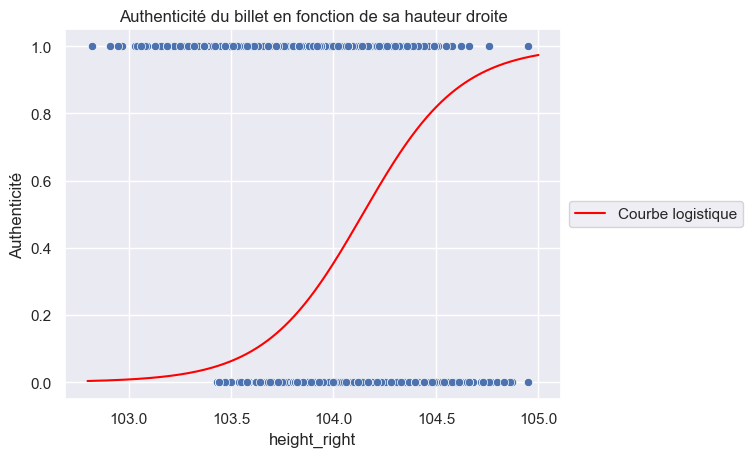

In [31]:
# nuage de points de l'authenticité du billet en fonction de height_right
ax = sns.scatterplot(x="height_right", y="is_genuine", data=billet)
plt.plot(reg_log["height_right"], reg_log["is_genuine"], color="red", label="Courbe logistique")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel("height_right")
plt.ylabel("Authenticité")
plt.title("Authenticité du billet en fonction de sa hauteur droite")
plt.show()

Nous constatons que l'authenticité du billet se vérifie avec l'augmentation de la hauteur droite (mesurée en milimètres) avec un fléchissement de la courbe logistique à partir de 103,5 mm jusqu'à l'authenticité totale à 105 mm.

Nous utilisons la même procédure pour les autres variables retenues.

<class 'statsmodels.iolib.summary.Summary'>
"""
                             Generalized Linear Model Regression Results                             
=====================================================================================================
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1500
Model:                                                   GLM   Df Residuals:                     1498
Model Family:                                       Binomial   Df Model:                            1
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -334.68
Date:                                       Sun, 18 Jun 2023   Deviance:                       669.35
Time:                                               10:19:11   Pearson chi2:                 1.76e+03
No. Iterations:                                            7   Pseudo R-squ. (CS):             0.5626
Covariance Type:                                   nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -29.5850      1.640    -18.041      0.000     -32.799     -26.371
margin_low     6.3376      0.359     17.647      0.000       5.634       7.042
==============================================================================
"""

,margin_low,is_genuine
0,2.950000,0.000019
1,2.958016,0.000020
2,2.966032,0.000021
3,2.974048,0.000022
4,2.982064,0.000023


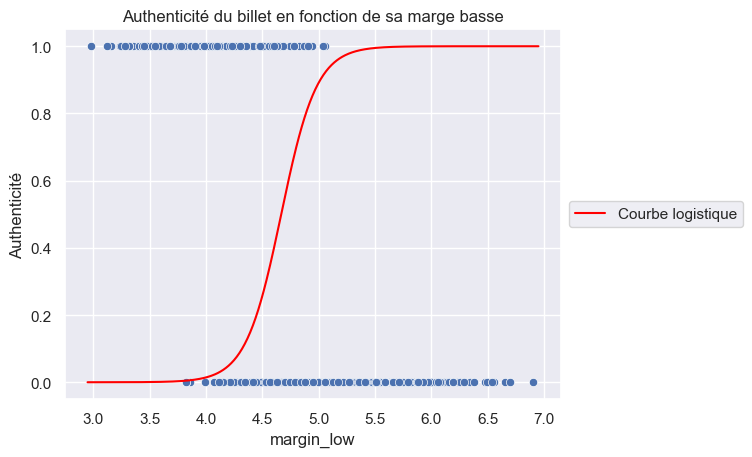

In [32]:
# Régression logistique avec la variable margin_low
reg_log1 = smf.glm("is_genuine~margin_low", data=billet, family=sm.families.Binomial()).fit()
display(reg_log1.summary())

# Récupération de Beta1 et Beta2
beta1 = reg_log1.params[0]
beta2 = reg_log1.params[1]

# Dataframe de la régression logistique
x = np.linspace(start=2.95, stop=6.95, num=500)
y = np.exp(beta1+beta2*x)/(1+np.exp(beta1+beta2*x))
reg_log1 = pd.DataFrame(data={"margin_low": x, "is_genuine": y})
display(reg_log1.head())

# nuage de points de l'authenticité du billet en fonction de margin_low
ax = sns.scatterplot(x="margin_low", y="is_genuine", data=billet)
plt.plot(reg_log1["margin_low"], reg_log1["is_genuine"], color="red", label="Courbe logistique")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel("margin_low")
plt.ylabel("Authenticité")
plt.title("Authenticité du billet en fonction de sa marge basse")
plt.show()

On observe que l'authenticité du billet se vérifie avec l'augmentation de la marge basse (mm) avec un fléchissement de la courbe à partir de 4 mm jusqu'à l'authenticité totale à 5 mm.

<class 'statsmodels.iolib.summary.Summary'>
"""
                             Generalized Linear Model Regression Results                             
=====================================================================================================
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1500
Model:                                                   GLM   Df Residuals:                     1498
Model Family:                                       Binomial   Df Model:                            1
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -619.34
Date:                                       Sun, 18 Jun 2023   Deviance:                       1238.7
Time:                                               10:19:12   Pearson chi2:                 1.36e+03
No. Iterations:                                            6   Pseudo R-squ. (CS):             0.3606
Covariance Type:                                   nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -28.4701      1.490    -19.108      0.000     -31.390     -25.550
margin_up      8.6769      0.461     18.816      0.000       7.773       9.581
==============================================================================
"""

,margin_up,is_genuine
0,2.250000,0.000130
1,2.253347,0.000134
2,2.256693,0.000138
3,2.260040,0.000142
4,2.263387,0.000146


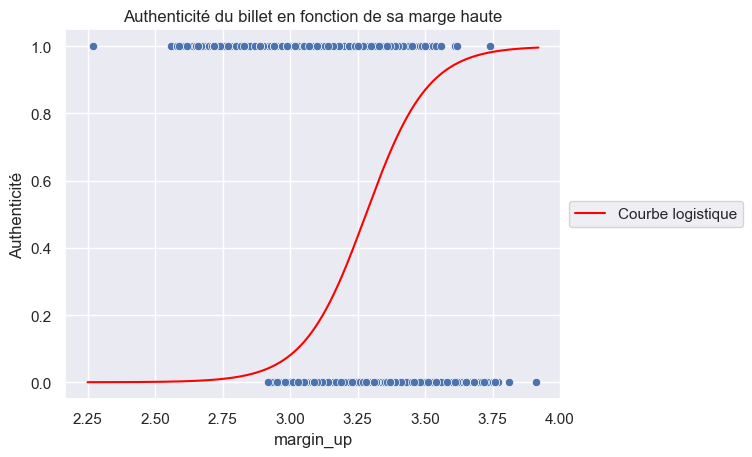

In [33]:
# Régression logistique avec la variable margin_up
reg_log1 = smf.glm("is_genuine~margin_up", data=billet, family=sm.families.Binomial()).fit()
display(reg_log1.summary())

# Récupération de Beta1 et Beta2
beta1 = reg_log1.params[0]
beta2 = reg_log1.params[1]

# Dataframe de la régression logistique
x = np.linspace(start=2.25, stop=3.92, num=500)
y = np.exp(beta1+beta2*x)/(1+np.exp(beta1+beta2*x))
reg_log1 = pd.DataFrame(data={"margin_up": x, "is_genuine": y})
display(reg_log1.head())

# nuage de points de l'authenticité du billet en fonction de margin_low
ax = sns.scatterplot(x="margin_up", y="is_genuine", data=billet)
plt.plot(reg_log1["margin_up"], reg_log1["is_genuine"], color="red", label="Courbe logistique")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel("margin_up")
plt.ylabel("Authenticité")
plt.title("Authenticité du billet en fonction de sa marge haute")
plt.show()

On observe que l'authenticité du billet se vérifie avec l'augmentation de la marge haute (mm) avec un fléchissement de la courbe à partir de 3 mm jusqu'à l'authenticité totale du billet à environ 3.90 mm.

<class 'statsmodels.iolib.summary.Summary'>
"""
                             Generalized Linear Model Regression Results                             
=====================================================================================================
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1500
Model:                                                   GLM   Df Residuals:                     1498
Model Family:                                       Binomial   Df Model:                            1
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -191.21
Date:                                       Sun, 18 Jun 2023   Deviance:                       382.43
Time:                                               10:19:12   Pearson chi2:                 1.22e+04
No. Iterations:                                            8   Pseudo R-squ. (CS):             0.6387
Covariance Type:                                   nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    741.9276     48.885     15.177      0.000     646.114     837.741
length        -6.5967      0.434    -15.193      0.000      -7.448      -5.746
==============================================================================
"""

,length,is_genuine
0,109.400000,1.0
1,109.410120,1.0
2,109.420240,1.0
3,109.430361,1.0
4,109.440481,1.0


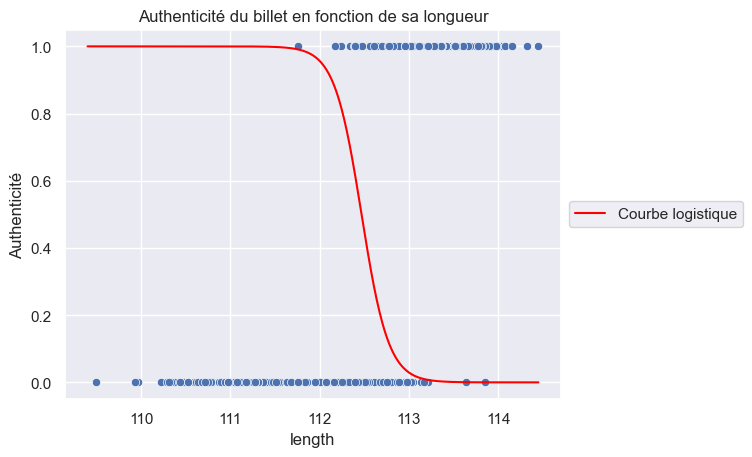

In [34]:
# Régression logistique avec la variable length
reg_log1 = smf.glm("is_genuine~length", data=billet, family=sm.families.Binomial()).fit()
display(reg_log1.summary())

# Récupération de Beta1 et Beta2
beta1 = reg_log1.params[0]
beta2 = reg_log1.params[1]

# Dataframe de la régression logistique
x = np.linspace(start=109.40, stop=114.45, num=500)
y = np.exp(beta1+beta2*x)/(1+np.exp(beta1+beta2*x))
reg_log1 = pd.DataFrame(data={"length": x, "is_genuine": y})
display(reg_log1.head())

# nuage de points de l'authenticité du billet en fonction de margin_low
ax = sns.scatterplot(x="length", y="is_genuine", data=billet)
plt.plot(reg_log1["length"], reg_log1["is_genuine"], color="red", label="Courbe logistique")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel("length")
plt.ylabel("Authenticité")
plt.title("Authenticité du billet en fonction de sa longueur")
plt.show()

On observe que l'authenticité du billet diminue avec l'augmentation de la longueur (mm) avec un fléchissement de la courbe à partir de 112 mm jusqu'à la non authenticité du billet à environ 113 mm.

# Matrice de confusion

La matrice de confusion est une table qui permet de visualiser la performance du modèle de classification en comparant les valeurs prédites aux valeurs réelles. Nous calculons la matrice de confusion sur le jeu de données complet cette fois-ci.

In [35]:
# Séparation du jeu de données en data (X) et target (Y)
X = billet[["diagonal","height_left","height_right","margin_low","margin_up","length"]]
Y = billet["is_genuine"]

In [36]:
# Prédiction de l'authenticité des billets sur le jeu de données complet
lr = LogisticRegression()
lr.fit(X,Y)
predicted = lr.predict(X)

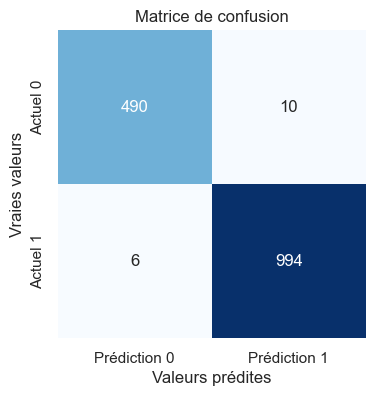

Exactitude :  0.99
Précision :  0.99
Rappel :  0.99
Score F1 :  0.99
AUC-ROC :  0.99


In [37]:
# Calcul de la matrice de confusion
y_true = Y
y_pred = predicted

confusion = confusion_matrix(y_true, y_pred)

# Affichage de la matrice de confusion
plt.figure(figsize=(4, 4))
sns.heatmap(confusion, annot=True, fmt='d', cmap="Blues", cbar=False, square=True,
            xticklabels=["Prédiction 0", "Prédiction 1"],
            yticklabels=["Actuel 0", "Actuel 1"])
plt.xlabel("Valeurs prédites")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de confusion")
plt.show()

# Calcul des différentes métriques de score de prédiction
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc_roc = roc_auc_score(y_true, y_pred)

# Affichage des scores
print("Exactitude : ", round(accuracy, 2))
print("Précision : ", round(precision, 2))
print("Rappel : ", round(recall, 2))
print("Score F1 : ", round(f1, 2))
print("AUC-ROC : ", round(auc_roc, 2))

Grâce à la matrice de confusion, sur les 500 faux billets, la régression logistique en prédit 490 faux et 10 vrais, tandis que sur les 1000 vrais billets elle en prédit 994 vrais et 6 faux.

Nous affichons de bons scores de prédiction à la hauteur de 99% en utilisant différentes métriques comme l'exactitude (accuracy), la précision (precision), le rappel (recall), le score F1 (F1-score) ou l'aire sous la courbe ROC (AUC-ROC).

# Prédiction de l'authenticité des billets avec la régression logistique

In [38]:
# Séparation du jeu de données en 80% d'entrainement et 20% test
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, train_size=0.8)

In [39]:
# Prédiction de l'authenticité des billets sur les données test
lr = LogisticRegression()
lr.fit(xtrain,ytrain)
predicted = lr.predict(xtest)

data_clustered = pd.DataFrame(xtest, index=xtest.index , columns=xtest.columns)
data_clustered["result"]=predicted
data_clustered.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,result
1294,172.40,104.27,104.18,4.92,3.17,111.79,False
1466,171.58,104.55,103.83,5.50,3.32,110.97,False
1424,171.68,103.90,104.41,4.74,3.29,111.85,False
755,171.62,104.12,103.81,4.38,3.13,112.64,True
1300,171.38,104.13,104.22,5.67,3.46,112.48,False


In [40]:
# Localisation et quantité de billets vrais ou faux prédis dans le jeu de données test
T = data_clustered.loc[data_clustered["result"]==1,:].copy()
F = data_clustered.loc[data_clustered["result"]==0,:].copy()

display(T.head())
display(T.shape)

display(F.head())
display(F.shape)

,diagonal,height_left,height_right,margin_low,margin_up,length,result
755,171.62,104.12,103.81,4.38,3.13,112.64,True
22,172.10,103.96,103.71,3.93,2.89,112.68,True
513,171.77,104.19,103.69,4.17,2.85,112.89,True
258,171.71,103.53,103.78,3.89,3.03,113.51,True
477,171.95,104.25,103.64,3.24,2.81,113.42,True


(203, 7)

,diagonal,height_left,height_right,margin_low,margin_up,length,result
1294,172.40,104.27,104.18,4.92,3.17,111.79,False
1466,171.58,104.55,103.83,5.50,3.32,110.97,False
1424,171.68,103.90,104.41,4.74,3.29,111.85,False
1300,171.38,104.13,104.22,5.67,3.46,112.48,False
1039,171.65,104.12,104.33,5.56,3.19,111.48,False


(97, 7)

# Méthode des K-means

La méthode k-means est une technique d'analyse de données non supervisée utilisée pour regrouper des observations en k clusters distincts en fonction de leurs similarités. Cette méthode implique l'affectation d'un point à un cluster en fonction de la distance entre les coordonnées du point et les coordonnées du centroïde du cluster le plus proche.

In [41]:
billet.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [42]:
# Remplacement des valeurs True et False, de la colonne "is_genuine", en binaire
billet["is_genuine"] = billet["is_genuine"].replace({True:1, False:0})
billet

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,0,171.75,104.38,104.17,4.42,3.09,111.28
1496,0,172.19,104.63,104.44,5.27,3.37,110.97
1497,0,171.80,104.01,104.12,5.51,3.36,111.95
1498,0,172.06,104.28,104.06,5.17,3.46,112.25


In [43]:
# Extraction des valeurs du dataset
X = billet.values

In [44]:
# Centrage et réduction des données
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
display(X_scaled)
display(X_scaled.shape)

# Vérification de la moyenne =0 et de l'écart type =1
pd.DataFrame(X_scaled).describe().round(2).iloc[1:3,:]

array([[ 0.70710678, -0.48653957,  2.77412327, ...,  0.05483885,
        -1.128325  ,  0.17365114],
       [ 0.70710678, -1.63372936, -2.23653528, ..., -1.08658023,
        -0.69679916,  0.47166629],
       [ 0.70710678,  2.3978233 ,  1.50475644, ..., -0.12778821,
        -0.91256208,  0.55190114],
       ...,
       [-1.41421356, -0.51931643, -0.06524991, ...,  1.56151202,
         0.89984645, -0.83501554],
       [-1.41421356,  0.3328817 ,  0.83666863, ...,  1.04406871,
         1.33137229, -0.4911519 ],
       [-1.41421356, -1.6009525 ,  0.40241156, ...,  0.22224698,
         0.94299904, -0.69747008]])

(1500, 7)

,0,1,2,3,4,5,6
mean,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [45]:
# Classification en composante principale
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_scaled)

PCA()

In [46]:
# Matrice de l'ACP
X_proj = pca.transform(X_scaled)
X_proj = pd.DataFrame(X_proj, columns=["PC1","PC2","PC3", "PC4","PC5","PC6","PC7"])
display(X_proj.head())
X_proj.shape

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,0.957529,0.926702,2.875048,3.026308,-0.049663,0.118165,-0.726870
1,-2.055622,-2.269620,-1.008001,0.157085,-0.032622,-0.519251,0.105346
2,-1.219520,2.606890,0.961050,-1.160471,0.850301,0.227869,-0.079782
3,-1.559184,-1.809040,0.780579,0.800662,-0.646607,-0.301685,0.239450
4,-0.231698,-0.520966,0.829209,-1.691689,-1.397141,-0.223642,-0.612602


(1500, 7)

In [47]:
# Méthode des K-means
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_scaled)
labels = kmeans.labels_
labels

array([1, 0, 0, ..., 1, 1, 1])

Nous identifions tout d'abord 2 clusters qui pourraient correspondre aux 2 catégories "Vrai" et "Faux" billets.

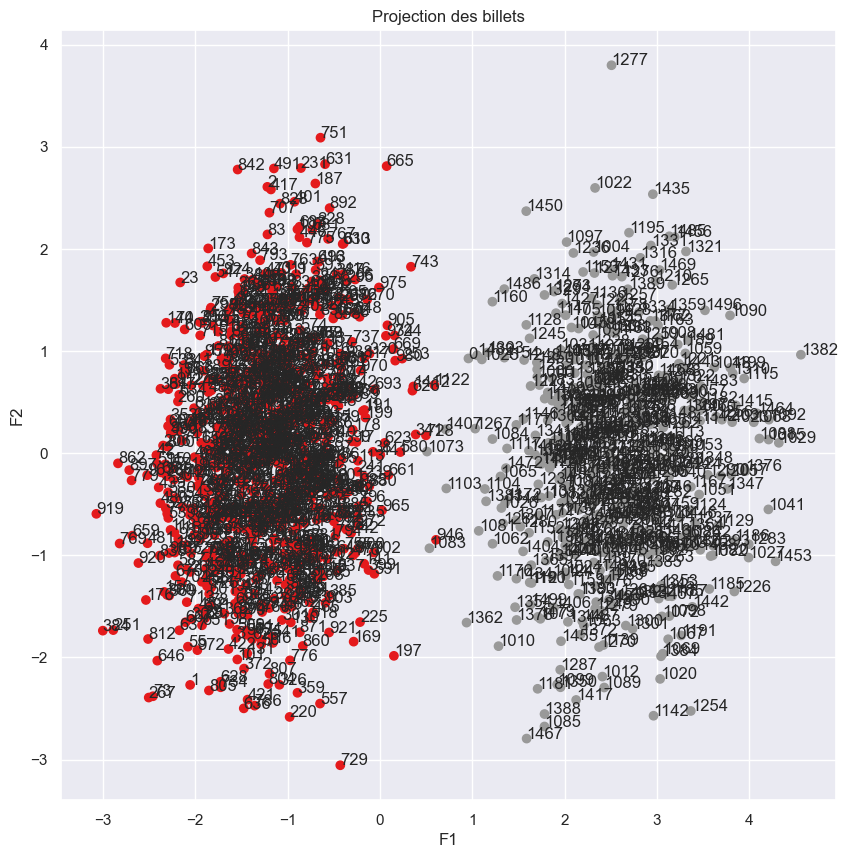

In [48]:
# Représentation graphique du clustering
fig, ax = plt.subplots(1,1,figsize=(10,10))

ax.scatter(X_proj.iloc[:,0], X_proj.iloc[:,1], c=labels, cmap="Set1")

for i, (x, y) in enumerate(zip(X_proj.iloc[:,0],
                               X_proj.iloc[:,1])):
    plt.text(x, y, billet.index[i])

ax.set_xlabel("F1")
ax.set_ylabel("F2")
ax.set_title("Projection des billets")
plt.show()

2 grands groupes bien définis se dégagent du jeu de données. 
Vérifions maintenant le nombre de clusters idéal grâce à des algorithmes non supervisés comme le score Elbow, le coefficient de silhouette et l'indice de Davies Bouldin.

# Détermination du nombre de clusters avec des algorithmes

In [49]:
# Inertie des clusters ou calcul de la somme des carrés des distances
from sklearn.cluster import KMeans

inertia_list =[]

k_list = range(1,10)

for k in k_list:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertia_list.append(kmeans.inertia_)

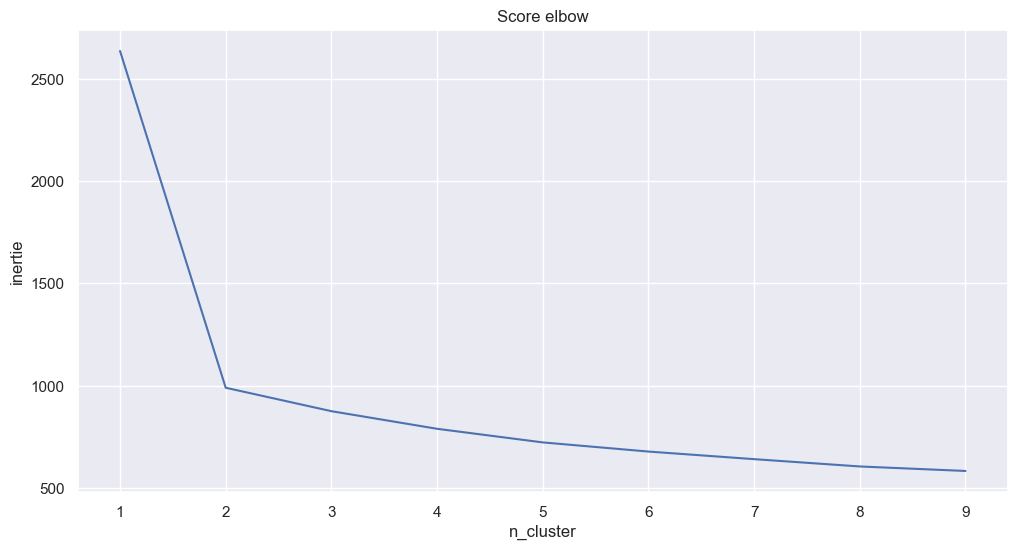

In [50]:
# Représentation graphique du score elbow
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("inertie")
ax.set_xlabel("n_cluster")
ax.set_title("Score elbow")
ax = plt.plot(k_list, inertia_list)

plt.show()

A première vue le score Elbow présente sa cassure au niveau de 2 clusters.

In [51]:
# Résultats du coefficient de silhouette en fonction du nombre de clusters testés
from sklearn.metrics import silhouette_score

def kmeans_results(X):
     
    # Test des résultats pour n_clusters compris entre 2 et 5
    for k in range(2, 6):
        kmeans = KMeans(n_clusters=k).fit(X_scaled)
        inertia = kmeans.inertia_
        silhouette_coefficient = np.mean(silhouette_score(X_scaled, kmeans.labels_))
        print(f"Nombre de clusters : {k}")
        print(f"Inertie : {inertia:.2f}")
        print(f"Coefficient de silhouette : {silhouette_coefficient:.2f}\n")
        
kmeans_results(X)

Nombre de clusters : 2
Inertie : 5862.20
Coefficient de silhouette : 0.42

Nombre de clusters : 3
Inertie : 5146.48
Coefficient de silhouette : 0.24

Nombre de clusters : 4
Inertie : 4743.78
Coefficient de silhouette : 0.23

Nombre de clusters : 5
Inertie : 4412.51
Coefficient de silhouette : 0.16



Le coefficient de silhouette exprime le nombre optimal de clusters. Il évolue entre -1 et 1. 1 représentant la meilleure stabilité du cluster. Il indique ici que le nombre de clusters idéal est de 2.
Nous paramétrons définitivement le K-means sur 2 clusters. Vérifions maintenant la valeur de l'indice de Davies Bouldin.

In [52]:
# K-means
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_scaled)
labels = kmeans.labels_
labels

array([0, 1, 1, ..., 0, 0, 0])

In [53]:
# Indice de Davies Bouldin
from sklearn.metrics import davies_bouldin_score

score = davies_bouldin_score(X_scaled, labels)
print("L'indice de Davies-Bouldin est :", score)

L'indice de Davies-Bouldin est : 1.0153335829116115


L'indice de Davies-Bouldin exprime la moyenne du rapport maximal entre la distance d'un point au centre de son groupe et la distance entre deux centres de groupes. L'indice varie entre 0 (meilleure classification) et + l'infini (pire classification). Notre indice est proche de 1 ce qui démontre une bonne classification.

In [54]:
# Création d'une fonction pour la projection des valeurs en clusters sur un plan à 2 dimensions

def display_factorial_planes(   X_proj, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="o" ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en un df
    X_ = pd.DataFrame(X_proj)
    
    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # On définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # On rajoute la color, les clusters et les labels à X_
    X_["clusters"] =  clusters if clusters is not None else "None" 
    X_["labels"] =  labels if labels is not None else "None"
    c_unique_list = X_["clusters"].sort_values().unique()
    c_dict = {j:i+1 for i, j in enumerate(c_unique_list)}
    X_["colors"] = X_["clusters"].apply(lambda i : c_dict[i])

    # Pour chaque couleur / cluster
    for c in sorted(X_.clusters.unique()) : 
        # On selectionne le sous DF
        sub_X =X_.loc[X_.clusters == c, : ]

        # Clusters and color
        cluster = sub_X.clusters.iloc[0]
        color = sub_X.colors.iloc[0]

        # On affiche les points
        ax.scatter(    sub_X.iloc[:, x], 
                        sub_X.iloc[:, y], 
                        alpha=alpha, 
                        label = cluster ,
                        cmap="Set1", 
                        marker=marker)
        
    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_.iloc[:, x]).max() *1.1
    y_max = np.abs(X_.iloc[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if labels :         
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y, labels[i], fontsize='14', ha='center',va='center') 

    # Titre, legend et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    if clusters is not None: 
        plt.legend()
    plt.show()


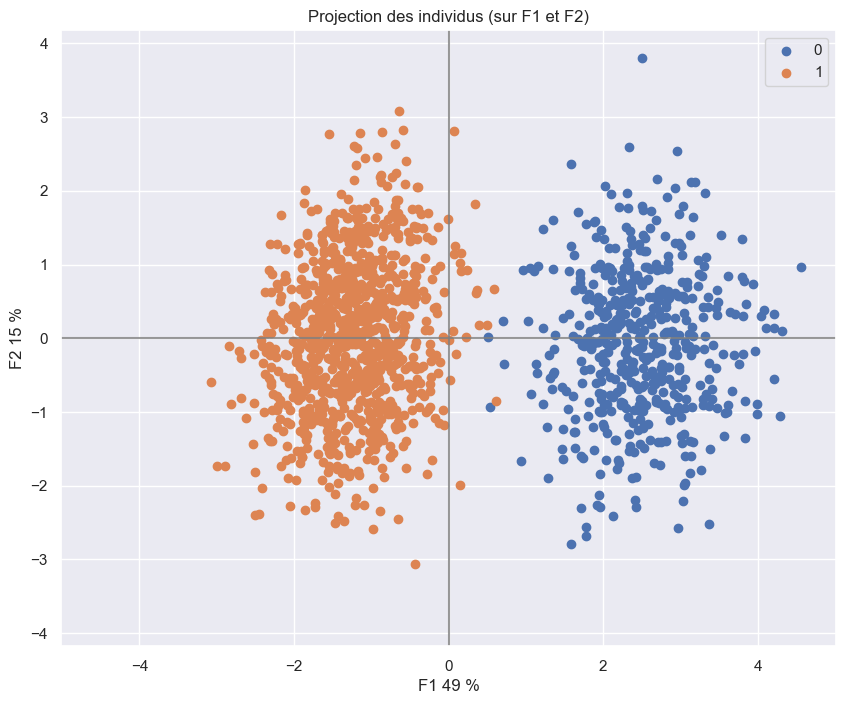

In [55]:
display_factorial_planes(X_proj,  
                         x_y=(0,1), 
                         clusters=labels, 
                         pca=pca, 
                         figsize=(10, 8), 
                         alpha=1 )

# Calcul des centroïdes

In [56]:
# Calcul des centroides
centroids = kmeans.cluster_centers_
centroids.shape

(2, 7)

In [57]:
# Calcul des centroides centrés et réduits
centroids_scaled = scaler.fit_transform(centroids)
centroids_scaled.shape

(2, 7)

In [58]:
# Calcul des centroides en fonction du nombre de clusters définis
centroids_proj = pca.transform(centroids_scaled)
centroids_proj = pd.DataFrame(centroids_proj, columns=["F1","F2","F3", "F4", "F5","F6","F7"], index=["cluster_0", "cluster_1"])
centroids_proj

,F1,F2,F3,F4,F5,F6,F7
cluster_0,2.464936,-0.587532,0.609681,0.247564,-0.328562,0.092672,-0.171342
cluster_1,-2.464936,0.587532,-0.609681,-0.247564,0.328562,-0.092672,0.171342


In [59]:
# Calcul des centroides pour chaque variable
centroids_proj = scaler.transform(centroids)
centroids_proj = pd.DataFrame(centroids_proj)
centroids_proj

,0,1,2,3,4,5,6
0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0
1,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0


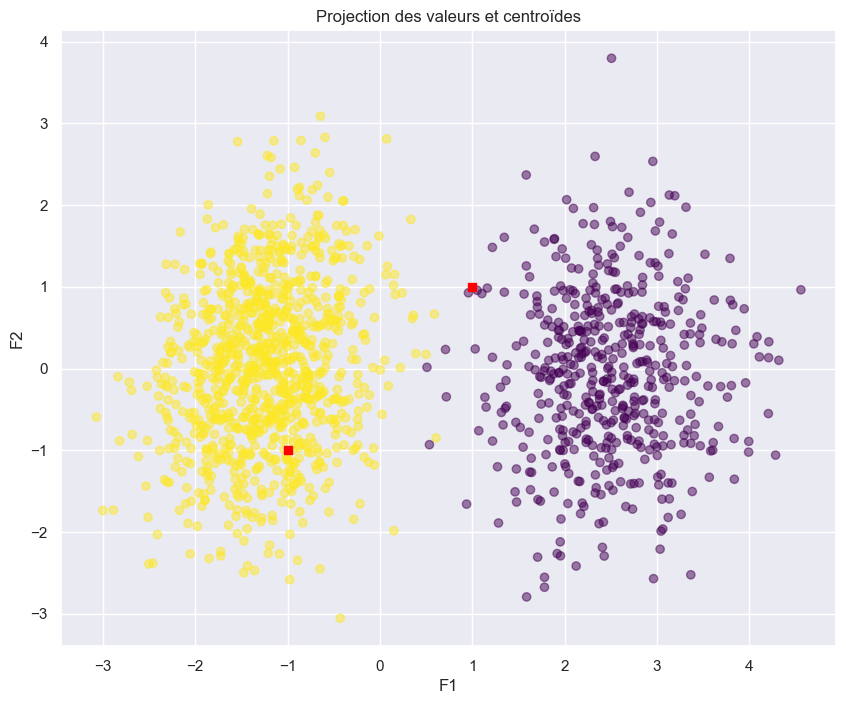

In [60]:
# Projection des valeurs en clusters et des centroides (carrés noirs)
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.scatter(X_proj.iloc[:,0], X_proj.iloc[:,1], c=labels, cmap="viridis", alpha=0.5)
ax.scatter(centroids_proj.iloc[:,0], centroids_proj.iloc[:,1], c="red", marker="s")
ax.set_xlabel("F1")
ax.set_ylabel("F2")

ax.set_title("Projection des valeurs et centroïdes")

plt.show()

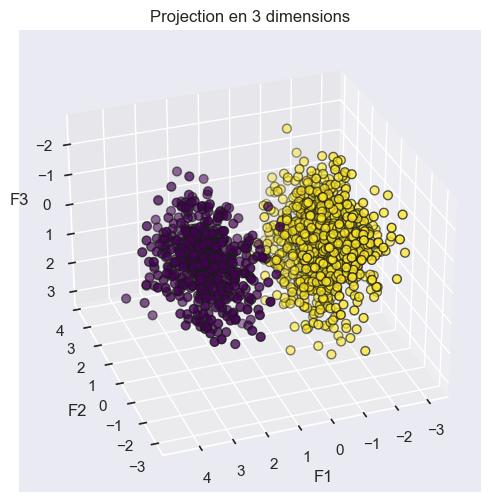

In [61]:
# Représentation en 3 dimensions

fig = plt.figure(1, figsize=(8,6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

ax.scatter(
    X_proj.iloc[:,0],
    X_proj.iloc[:,1],
    X_proj.iloc[:,2],
    c=labels, cmap="viridis", edgecolor="k", s=40)

ax.set_xlabel("F1")
ax.set_ylabel("F2")
ax.set_zlabel("F3")
ax.set_title("Projection en 3 dimensions")

plt.show()

# Prédiction de l'authenticité des billets avec la méthode K-means

Nous allons tout d'abord prédire l'authenticité des billets sur le jeu de données entier pour déterminer les clusters vrais et faux billets.

Ensuite nous entrainerons le modèle K-means sur les données d'entrainement, soit 80% du jeu de données, puis nous testerons le modèle sur les données "test", soit les 20% restants.

In [62]:
# Détermination des clusters vrais et faux en testant le jeu de données entier
model_kmeans = KMeans(n_clusters=2, init="k-means++")
model_kmeans.fit(X_scaled)

# Déterminer les clusters auxquels appartiennent chaque point de données
clusters_predicted =  model_kmeans.fit_predict(X_scaled)

# Ajouter le numéro de cluster aux données à l’échelle originale
billet_clustered = pd.DataFrame(X_scaled, index=billet.index, columns=billet.columns).reset_index()
billet_clustered["cluster"] = clusters_predicted

billet_clustered.head()

,index,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,cluster
0,0,0.707107,-0.486540,2.774123,3.163240,0.054839,-1.128325,0.173651,0
1,1,0.707107,-1.633729,-2.236535,-0.799668,-1.086580,-0.696799,0.471666,1
2,2,0.707107,2.397823,1.504756,-1.291191,-0.127788,-0.912562,0.551901,1
3,3,0.707107,-1.961498,-0.399294,0.060498,-1.314864,-0.610494,0.953075,1
4,4,0.707107,-0.748754,0.836669,-1.414072,-0.675669,1.417677,-0.158750,1


In [63]:
# Liste des billets prédis rangés par cluster 
for k in range(0,2):
    liste_billet = billet_clustered.loc[billet_clustered["cluster"]==k, "index"].to_list()
    unique_values = set(liste_billet)
    n_billet = len(unique_values)
    print("\nCluster", k, "(", n_billet, "billet) :\n", liste_billet)


Cluster 0 ( 499 billet) :
 [0, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 11

D'après la prédiction nous constatons que le cluster 0 représente les billets authentiques avec 1001 billets, tandis que le cluster 1 représente les faux billets avec 499 billets.

La prédiction est quasi identique au jeu de données initial qui annonce 1000 vrais billets et 500 faux billets.
Nous notons que notre modèle a identifié un billet normalement faux comme étant vrai.

Maintenant que nous avons identifié les correspondances des clusters, nous pouvons entraîner notre modèle sur 80% du dataset et nous testeronsla prédiction sur les 20% restants.

# Matrice de confusion

Nous calculons la matrice de confusion sur le jeu de données complet.

In [64]:
# Récupération des données centrées et réduites sous forme d'un dataframe
billet_data = pd.DataFrame(X_scaled, index=billet.index, columns=billet.columns)

X_data = billet_data[["diagonal", "height_left","height_right", "margin_low", "margin_up", "length"]]
display(X_data.head())
display(X_data.shape)

Y_target = billet_data["is_genuine"]
display(Y_target.head())
display(Y_target.shape)

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.486540,2.774123,3.163240,0.054839,-1.128325,0.173651
1,-1.633729,-2.236535,-0.799668,-1.086580,-0.696799,0.471666
2,2.397823,1.504756,-1.291191,-0.127788,-0.912562,0.551901
3,-1.961498,-0.399294,0.060498,-1.314864,-0.610494,0.953075
4,-0.748754,0.836669,-1.414072,-0.675669,1.417677,-0.158750


(1500, 6)

0    0.707107
1    0.707107
2    0.707107
3    0.707107
4    0.707107
Name: is_genuine, dtype: float64

(1500,)

In [65]:
# Détermination des clusters
model_kmeans = KMeans(n_clusters=2, init="k-means++")
model_kmeans.fit(X_data)

# Prédiction des clusters
clusters_predicted =  model_kmeans.fit_predict(X_data)

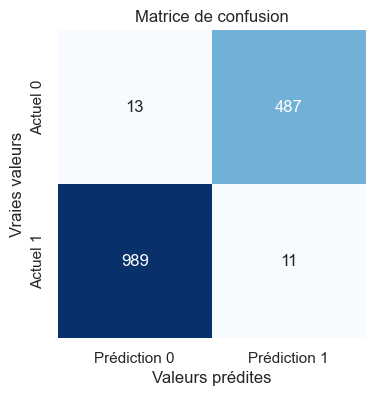

In [66]:
# Calcul de la matrice de confusion
y_true = Y
y_pred = clusters_predicted

confusion = confusion_matrix(y_true, y_pred)

# Affichage de la matrice de confusion
plt.figure(figsize=(4, 4))
sns.heatmap(confusion, annot=True, fmt='d', cmap="Blues", cbar=False, square=True,
            xticklabels=["Prédiction 0", "Prédiction 1"],
            yticklabels=["Actuel 0", "Actuel 1"])
plt.xlabel("Valeurs prédites")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de confusion")
plt.show()

Pour éviter toute confusion, je rappelle que le cluster 0 contient les vrais billets (True remplacé par 1 dans la prédiction) et que le cluster 1 contient les faux billets (False remplacé par 0 dans la prédiction).

Grâce à la matrice de confusion, sur les 500 faux billets, la méthode du K-means prédit 487 faux billets (cluster 1) et 13 vrais billets (cluster 0). Tandis que sur les 1000 vrais billets, elle en prédit 989 vrais (cluster 0) et 11 faux (cluster 1).

# Entraînement et test du modèle K-means

In [67]:
# Séparation du jeu de données à 80 % en entrainement et 20 % en test
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X_data, Y_target, train_size=0.8)

In [68]:
# Détermination des clusters
model_kmeans = KMeans(n_clusters=2, init="k-means++")
model_kmeans.fit(xtrain)

# Prédiction des clusters
clusters_predicted =  model_kmeans.fit_predict(xtest)

# Ajout du numéro de cluster aux données à l’échelle originale
billet_clustered = pd.DataFrame(xtest, index=xtest.index, columns=xtest.columns).reset_index()
billet_clustered["cluster"] = clusters_predicted

billet_clustered.head()

,index,diagonal,height_left,height_right,margin_low,margin_up,length,cluster
0,111,0.234551,-0.232272,-1.045430,-0.645232,-1.300935,0.391431,1
1,829,0.988419,0.369007,-0.584626,-0.112569,-0.826257,0.265348,1
2,1118,-1.895944,1.638374,0.920664,0.146152,1.115609,-0.961099,0
3,1386,0.300105,0.636242,0.398421,2.109393,0.123100,-1.774909,0
4,934,0.693427,0.803264,1.227867,0.054839,0.727236,0.918689,0


In [69]:
# Liste des clusters des billets prédis
display(clusters_predicted)
clusters_predicted.shape

array([1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1])

(300,)

Le modèle a prédit l'authenticité ou non des billets pour 300 valeurs tests, ce qui représente bien 20% du dataset.
Comme vu précédemment, le cluster 0 représentent les billets authentiques et le cluster 1 les faux billets.

In [70]:
# Liste des billets prédis, rangés par cluster 
for k in range(0,2):
    liste_billet = billet_clustered.loc[billet_clustered["cluster"]==k, "index"].to_list()
    unique_values = set(liste_billet)
    n_billet = len(unique_values)
    print("\nCluster", k, "(", n_billet, "billet) :\n", liste_billet)


Cluster 0 ( 99 billet) :
 [1118, 1386, 934, 1372, 1473, 1291, 1143, 1234, 1449, 1203, 1101, 1186, 1221, 1107, 1127, 1285, 1365, 1011, 1217, 1258, 0, 1093, 1346, 1003, 1470, 1497, 1024, 1354, 1006, 1331, 1466, 1166, 1009, 1437, 1117, 1260, 1444, 1343, 1033, 1190, 1211, 1287, 1252, 1091, 1379, 1022, 1303, 1373, 1245, 1175, 1456, 1352, 1213, 1229, 1214, 1315, 1457, 1489, 728, 1058, 1284, 1390, 1397, 1435, 341, 1366, 1228, 1082, 580, 1330, 1443, 1302, 1106, 1486, 1199, 1283, 1005, 1080, 1338, 1076, 1493, 1153, 1231, 1347, 1179, 1021, 1027, 1185, 1308, 1340, 1396, 1038, 1440, 1145, 1204, 1485, 1075, 1164, 1374]

Cluster 1 ( 201 billet) :
 [111, 829, 93, 781, 463, 944, 734, 594, 567, 853, 555, 658, 809, 993, 33, 387, 162, 838, 510, 808, 396, 136, 757, 389, 385, 706, 726, 845, 538, 345, 604, 682, 988, 432, 32, 394, 426, 340, 181, 143, 800, 254, 887, 979, 468, 353, 847, 154, 249, 402, 482, 395, 771, 293, 675, 271, 963, 49, 969, 798, 885, 27, 756, 816, 571, 719, 193, 500, 618, 201, 246, 805, 5

Nous retrouvons la liste des billets triés dans leur cluster respectif.

# Choix du modèle de prédiction

En terme de choix de modèle pour prédire au mieux l'authenticité d'un billet, nous nous orienterons plutôt vers la régression logistique dont la prédiction est plus proche de la réalité selon la matrice de confusion. 

Je rappelle que la régression avait fait seulement 10 mauvaises prédictions dans les faux billets et 6 dans les vrais, contre 13 mauvaises prédictions dans les faux billets et 11 dans les vrais pour la méthode K-means.

De plus, les scores de prédiction de la régression sont de l'ordre de 99% de qualité.

# Application du machine learning

Nous allons créer une fonction de machine learning, selon la méthode de régression logistique, qui permettra de prédire l'authenticité ou non des billets dans n'importe quel jeu de données.

Une première fonction servira à afficher les données prédites sous forme d'array, tandis qu'une deuxième fonction affichera ces prédictions directement dans le dataframe sous forme d'une nouvelle colonne "predictions".

### Fonction 1 : predict_logistic_regression

In [71]:
"""
Fonction de machine learning de prédiction de l'authenticité des billets pour n'importe quel jeu de données.

"""

def predict_logistic_regression(data_path):
    
    # Charger le fichier CSV
    data = pd.read_csv(data_path)
    
    # Séparation du jeu de données en caractéristiques (X), target (Y) et test (test_X)
    X = billet[["diagonal","height_left","height_right","margin_low","margin_up","length"]]
    Y = billet["is_genuine"]
    test_X = data.iloc[:,:-1]
    
    # Prédiction de l'authenticité des billets sur le jeu de données complet
    lr = LogisticRegression()
    lr.fit(X,Y)
    
    # Faire des prédictions sur les données de test
    predictions = lr.predict(test_X)

    return predictions

La fonction est prête à l'emploi, il suffit de renseigner comme argument le chemin d'accès du fichier à prédire.

In [72]:
# FONCTION 1 POUR LE TEST DE NOUVEAUX DATASETS
predict_logistic_regression(r"C:\Users\open_\Desktop\DATA ANALYST\10 - PROJETS\Projet 10\Projet - données\billets_production.csv")

array([0, 0, 0, 1, 1], dtype=int64)

### Fonction 2 : predict_logistic_regression_display

In [73]:
"""
Fonction de machine learning de prédiction de l'authenticité des billets pour n'importe quel jeu de données,
avec intégration des résultats dans le dataframe sous forme de valeurs booléennes.

"""

def predict_logistic_regression_display(data_path):
    
    # Charger le fichier CSV
    data = pd.read_csv(data_path)
    
    # Séparation du jeu de données en caractéristiques (X), target (Y) et test (test_X)
    X = billet[["diagonal","height_left","height_right","margin_low","margin_up","length"]]
    Y = billet["is_genuine"]
    test_X = data.iloc[:,:-1]
    
    # Prédiction de l'authenticité des billets sur le jeu de données complet
    lr = LogisticRegression()
    lr.fit(X,Y)
    
    # Prédictions sur les données de test
    predictions = lr.predict(test_X)
    
    # Conversion des valeurs prédites en True ou False
    predictions = predictions.astype(bool)

    # Création d'une nouvelle colonne dans le jeu de données pour les valeurs prédites
    data_predicted = data.copy() # Copie du jeu de données d'origine
    data_predicted["predictions"] = predictions # Ajout des valeurs prédites dans la nouvelle colonne
    
    # Affichage du nombre de valeurs prédites vraies et fausses
    vrai = (data_predicted["predictions"]==True).sum()
    faux = (data_predicted["predictions"]==False).sum()
    total = data_predicted.shape[0]
    print("Vrais billets :", vrai)
    print("Faux billets :", faux)
    print("Nombre total :", total)

    return data_predicted

La fonction 2 agit à l'identique de la première à la différence qu'elle affiche cette fois-ci le résultat de la prédiction directement dans le dataframe dans une nouvelle colonne predictions.

Il suffit toujours de renseigner comme argument le chemin d'accès du dataframe à prédire.

In [74]:
# FONCTION 2 POUR LE TEST DE NOUVEAUX DATASETS
predict_logistic_regression_display(r"C:\Users\open_\Desktop\DATA ANALYST\10 - PROJETS\Projet 10\Projet - données\billets_production.csv")

Vrais billets : 2
Faux billets : 3
Nombre total : 5


,diagonal,height_left,height_right,margin_low,margin_up,length,id,predictions
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,False
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,False
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,False
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,True
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,True


# <font color="#0000ff"> ! Fonction de prédiction pour l'examen !
    
    La fonction suivante servira à la prédiction du modèle délivrée par l'examinateur.

In [75]:
# FONCTION POUR LE TEST DE NOUVEAUX DATASETS
#predict_logistic_regression_display()

# Enregistrement du modèle avec Pickle

Pickle permet d'enregistrer et de charger des modèles d'apprentissage automatique. Cela permet de les partager ou les réexécuter plus tard sans avoir besoin d'une nouvelle formation chronophage du modèle (suivant la taille du jeu de données).

Nous allons d'abord enregistrer dans Pickle un premier modèle entraîné sur un jeu de données "train et test" découpé en 80/20 pour vérifier son bon fonctionnement. 

Puis nous enregistrerons un deuxième modèle entraîné sur le jeu de données complet afin de tester n'importe quel dataset.

### 1er enregistrement Pickle

In [76]:
# Séparation du jeu de données en 80% d'entrainement et 20% test
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, train_size=0.8)

# configuration d'un modèle de régression linéaire
lr = LogisticRegression()
lr.fit(xtrain,ytrain)

C:\Users\open_\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [77]:
# Enregistrement du modèle avec Pickle
pickle.dump(lr, open('lr.pkl', 'wb'))

In [78]:
# Chargement du modèle depuis Pickle
pickled_lr = pickle.load(open('lr.pkl', 'rb'))
display(pickled_lr.predict(xtest))
pickled_lr.predict(xtest).shape

array([False,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True, False, False,  True,  True,  True, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True, False, False,
        True, False, False,  True,  True, False, False,  True,  True,
        True,  True,  True,  True,  True, False, False,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True, False,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True, False, False, False, False,
        True,  True,  True, False,  True, False, False,  True,  True,
       False,  True,  True,  True,  True,  True, False,  True,  True,
       False, False,  True,  True, False, False, False, False,  True,
        True, False,  True, False, False, False,  True, False,  True,
        True, False,  True,  True,  True,  True, False, False,  True,
        True, False,

(300,)

Le modèle a bien été save/load et il prédit l'authenticité des billets sur les données tests.

### 2ème enregistrement Pickle

In [79]:
# Séparation du jeu de données en caractéristiques (X), target (Y) et test (X_test)
X = billet[["diagonal","height_left","height_right","margin_low","margin_up","length"]]
Y = billet["is_genuine"]

# Configuration d'un modèle de régression linéaire
lr = LogisticRegression()
lr.fit(X,Y)

LogisticRegression()

In [80]:
# Enregistrement du modèle avec Pickle
pickle.dump(lr, open('lr.pkl', 'wb'))

In [81]:
"""
Fonction de machine learning de prédiction de l'authenticité des billets pour n'importe quel jeu de données,
avec intégration des résultats dans le dataframe sous forme de valeurs booléennes,
chargé depuis Pickle.

"""

def predict_logistic_regression_pickle(data_path):
    
    # Charger le fichier CSV
    data = pd.read_csv(data_path)
    
    # Chargement du modèle depuis Pickle
    pickled_lr = pickle.load(open('lr.pkl', 'rb'))

    # Détermination du dataset à tester
    X_test = data.iloc[:,:-1]
    
    # Exécution du modèle
    predictions = pickled_lr.predict(X_test)
    
    # Conversion des valeurs prédites en True ou False
    predictions = predictions.astype(bool)

    # Création d'une nouvelle colonne dans le jeu de données pour les valeurs prédites
    data_predicted = data.copy() # Copie du jeu de données d'origine
    data_predicted["predictions"] = predictions # Ajout des valeurs prédites dans la nouvelle colonne
    
    # Affichage du nombre de valeurs prédites vraies et fausses
    vrai = (data_predicted["predictions"]==True).sum()
    faux = (data_predicted["predictions"]==False).sum()
    total = data_predicted.shape[0]
    print("Vrais billets :", vrai)
    print("Faux billets :", faux)
    print("Nombre total :", total)

    return data_predicted

Ce deuxième enregistrement Pickle est opérationnel pour prédire l'authenticité des billets de n'importe quel dataset présentant uniquement les valeurs géométriques.

Il est enregistré dans la fonction predict_logistic_regression_pickle et il suffit de renseigner le nom du dataset à tester.

In [82]:
# FONCTION PICKLE POUR LE TEST DE NOUVEAUX DATASETS
predict_logistic_regression_pickle(r"C:\Users\open_\Desktop\DATA ANALYST\10 - PROJETS\Projet 10\Projet - données\billets_production.csv")

Vrais billets : 2
Faux billets : 3
Nombre total : 5


,diagonal,height_left,height_right,margin_low,margin_up,length,id,predictions
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,False
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,False
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,False
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,True
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,True


# <font color="#0000ff"> ! Fonction de prédiction pour l'examen, avec Pickle !
    
    La fonction suivante servira à la prédiction du modèle délivrée par l'examinateur.

In [83]:
# FONCTION PICKLE POUR LE TEST DE NOUVEAUX DATASETS
#predict_logistic_regression_pickle()